In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import numpy as np
import torch_geometric.utils as utils

from tqdm.notebook import tqdm
from torch.nn import Linear, ReLU
from torch.nn import CrossEntropyLoss
from torch_geometric.nn.conv import APPNP
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.nn import Sequential, GCNConv, MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import GCNConv, global_mean_pool

In [79]:
dataset = Planetoid(root='planetoid', name='CITESEER')
train_loader =  DataLoader(dataset, batch_size =4, shuffle = True)
data = dataset[0]
print(data)

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


In [73]:
class GNN(nn.Module):
    def __init__(self, input_dim, num_classes):#input_dim have to be nfeatures
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, 64)
        self.conv2 = GCNConv(64, 64)
        self.conv3 = GCNConv(64, num_classes)
        self.APPNP = APPNP(num_classes, num_classes)
    
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index)
        edge_weight = x
        x = self.APPNP(x, edge_index)
        
        return x 

In [74]:
input_dim = data['x'].size()[1]
num_classes = len(np.unique(np.array(data['y'])))

model = GNN(input_dim = input_dim, num_classes=num_classes)

In [75]:
NUM_EPOCS = 100
LEARNING_RATE = 0.001

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

epoch_stats = {'loss': [], 'accuracy': []}

for epoch in tqdm(range(NUM_EPOCS)):
    #Forward run the modell one step
    model.train()
    running_loss = 0
    running_corrects = 0
    
    for data_batch in train_loader:
        idx = data_batch.edge_index
        labels = data_batch.y
        optimizer.zero_grad()
        
        model_preds = model(data_batch.x, idx)
        preds = torch.argmax(model_preds, dim=1)
        loss = criterion(model_preds, data_batch.y)
        loss.backward()
        optimizer.step()

        # Collect statistics
        running_loss += loss * idx.size(0)
        running_corrects += torch.sum(preds == labels)
        #print(preds)
        
    # Collect statistics
    epoch_stats['loss'].append(running_loss / len(train_loader.dataset))
    epoch_stats['accuracy'].append(running_corrects / (len(labels)))


  0%|          | 0/100 [00:00<?, ?it/s]

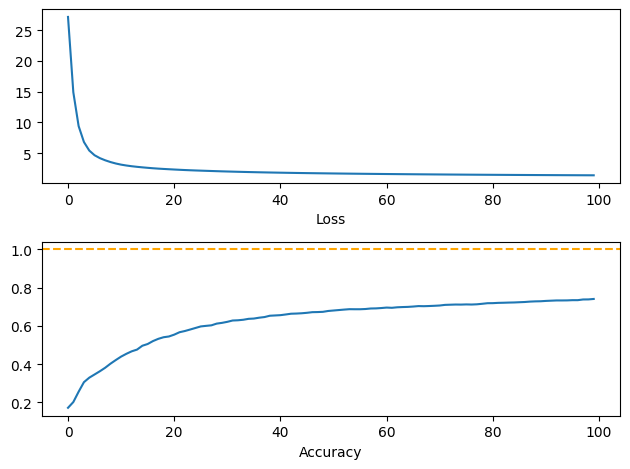

In [78]:
import matplotlib.pyplot as plt

with torch.no_grad():
    fig, axs = plt.subplots(2, 1)
    
    axs[0].plot(epoch_stats['loss'], label = "Loss")
    axs[0].set_xlabel('Loss')
    axs[1].plot(epoch_stats['accuracy'], label = "Accuracy")
    axs[1].axhline(y = 1.0, color = 'orange', linestyle = 'dashed')
    axs[1].set_xlabel('Accuracy')
    plt.tight_layout()
    plt.show()
    